In [3]:
import platform
platform.architecture()

('32bit', 'WindowsPE')

In [9]:
import pandas as pd
import numpy as np
import simfin as sf
from simfin.names import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

### Data Pulling (from SimFin) --> api_calls.py

In [10]:
API_KEY = 'MbOGeJgi6qQjgYbb58oBVQDaObxEZzXg'

# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key('MbOGeJgi6qQjgYbb58oBVQDaObxEZzXg')

In [11]:
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [12]:
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

df_fin_signals = hub.fin_signals(variant='daily')
df_growth_signals = hub.growth_signals(variant='daily')
df_val_signals = hub.val_signals(variant='daily')
print('DONE Data Pulling!')

Dataset "us-income-ttm" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (15 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... 

MemoryError: Unable to allocate 244. MiB for an array with shape (6, 5320790) and data type float64

### Data Cleaning/Manipulation

In [5]:
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

# Clip the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because scikit-learn cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()
print('DONE Data Cleaning/Manipulation')

Cache-file 'mean_log_change-5cec82bd.pickle' on disk (0 days old).
- Loading from disk ... Done!
DONE Data Cleaning/Manipulation


### Feature Engineering

In [24]:
# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with stock-returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

# List of signal names.
signal_names = X_train.columns.values

# List of signal names where spaces are replaced with _
signal_names_ = [s.replace(' ', '_') for s in signal_names]

# Column-name.
FEATURE_IMPORTANCE = 'Feature Importance'

def compare_feature_imp_corr(estimator):
    """
    Return a DataFrame which compares the signals' Feature
    Importance in the Machine Learning model, to the absolute
    correlation of the signals and stock-returns.

    :param estimator: Sklearn ensemble estimator.
    :return: Pandas DataFrame.
    """

    # Wrap the list of Feature Importance in a Pandas Series.
    df_feat_imp = pd.Series(estimator.feature_importances_,
                            index=signal_names,
                            name=FEATURE_IMPORTANCE)

    # Concatenate the DataFrames with Feature Importance
    # and Return Correlation.
    dfs = [df_feat_imp, df_corr_returns]
    df_compare = pd.concat(dfs, axis=1, sort=True)

    # Sort by Feature Importance.
    df_compare.sort_values(by=FEATURE_IMPORTANCE,
                           ascending=False, inplace=True)

    return df_compare

def print_tree(estimator, max_depth=6, **kwargs):
    """
    Print the first Decision Tree from a Random Forest.
    :param estimator: Sklearn ensemble estimator.
    """
    s = export_text(estimator.estimators_[0],
                    max_depth=max_depth,
                    feature_names=signal_names_,
                    **kwargs)
    print(s)

# Parameters for scikit-learn's Random Forest models.
model_args = \
{
    # Random Forest parameters to adjust between
    # over- and under-fitting.
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 100,
    'min_samples_leaf': 10,

    # Use all available CPU cores.
    'n_jobs': -1,

    # Set random seed to make the experiments repeatable.
    'random_state': 1234,
}
print('DONE Feature Engineering')

DONE Feature Engineering


### Training 🏋🏿🏋🏿🏋🏿🏋🏿🏋🏿

In [25]:
# Create the estimator, but don't do any computations yet.
regr = RandomForestRegressor(**model_args)

# Fit the estimator to the training-data.
# This may take several minutes on a 4-core CPU.
_ = regr.fit(X=X_train, y=y_train)

print_tree(regr)


|--- Earnings_Yield <= -0.02
|   |--- Asset_Turnover <= 0.44
|   |   |--- P/FCF <= -2.87
|   |   |   |--- Quick_Ratio <= 5.12
|   |   |   |   |--- Current_Ratio <= 3.13
|   |   |   |   |   |--- Return_on_Assets <= -0.23
|   |   |   |   |   |   |--- Interest_Coverage <= -1.98
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |--- Interest_Coverage >  -1.98
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- Return_on_Assets >  -0.23
|   |   |   |   |   |   |--- Sales_Growth_YOY <= 0.01
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |--- Sales_Growth_YOY >  0.01
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- Current_Ratio >  3.13
|   |   |   |   |   |--- (Dividends_+_Share_Buyback)_/_FCF <= 0.50
|   |   |   |   |   |   |--- Assets_Growth <= 0.32
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |--- Assets_Growth 

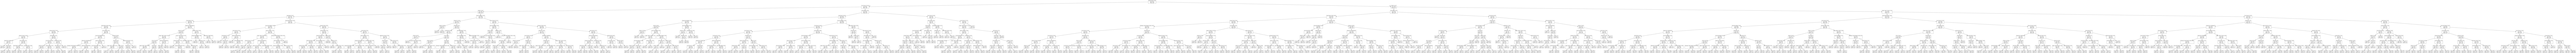

In [26]:
from sklearn.tree import export_graphviz
import pydot

estimator = regr.estimators_[5]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = signal_names_)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [27]:
y_hat = regr.predict(X_test)
print("residual %.2f" % np.mean((y_hat - y_test)**2))
print('variance score: %.2f' % regr.score(X_test, y_test))

residual 0.05
variance score: -0.09


In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_hat)

0.05007192388057254

In [13]:
from sklearn import linear_model
regr_mv = linear_model.LinearRegression()
regr_mv.fit(X_train,y_train)


LinearRegression()

In [14]:
y_hat_mv = regr_mv.predict(X_test)
print("residual %.2f" % np.mean((y_hat_mv - y_test)**2))
print('variance score: %.2f' % regr.score(X_test, y_test))

residual 0.05
variance score: 0.02


In [8]:
df_AAPL = sf.load_stock_data(ticker='AAPL')
df_AAPL.head()

AttributeError: module 'simfin' has no attribute 'load_stock_data'

### Testing 💯💯💯💯💯